In [10]:
##########################################################################
# ADD SOME GENERAL INFO and LICENSE -> @ajay6763
##########################################################################
from __future__ import division
import sys,os,time
import obspy
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.trigger import recursive_sta_lta_py
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.transforms as mtransforms
#import pygmt
import csv
import pandas as pd
import bp_lib
from joblib import Parallel, delayed
import obspy.geodetics

num_cores = 12
root_order = 2
corr_window=10
snr_window=10
extra_label='_10_sps'

file='input_default.csv'
input = pd.read_csv('./'+file,header=None)
a=input.to_dict('series')
keys = a[0][:]
values = a[1][:]
res = {}
for i in range(len(keys)):
        res[keys[i]] = values[i]
        #print(keys[i],values[i])

##########################################################################
# Event info

Event=res['Event']
event_lat=float(res['event_lat'])
event_long=float(res['event_long'])
event_depth=float(res['event_depth'])

Array_name=res['Array_name']
azimuth_min=float(res['azimuth_min'])
azimuth_max=float(res['azimuth_max'])
try:
    backazimuth_min=float(res['backazimuth_min'])
    backazimuth_max=float(res['backazimuth_max'])
except:
    pass
dist_min=float(res['dist_min'])
dist_max=float(res['dist_max'])
origin_time=obspy.UTCDateTime(int(res['origin_year']),int(res['origin_month']),
             int(res['origin_day']),int(res['origin_hour']),int(res['origin_minute']),float(res['origin_seconds']))
print(origin_time)

Focal_mech = dict(strike=float(res['event_strike']), dip=float(res['event_dip']), rake=float(res['event_rake'])
                  , magnitude=float(res['event_magnitude']))
stations = str(res['stations'])
waveforms= str(res['waveforms']) 
##########################################################################
# BP parameters
##########################################################################
model               = TauPyModel(model=str(res['model']))
Start_P_cut_time    = float(res['Start_P_cut_time'])  #before P arrival in seconds
End_P_cut_time      = float(res['End_P_cut_time']) #After P arrival seconds
sps                 = float(res['sps'])  #samples per seconds
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
bp_l                = float(res['bp_l']) #Hz
bp_u                = float(res['bp_u'])   #Hz
stack_start         = int(res['stack_start'])   #in seconds
stack_end           = int(res['stack_end'])  #in seconds
STF_start           = int(res['STF_start'])
STF_end             = int(res['STF_end'])
#smooth_time_window  = int((STF_end-STF_start)/10) #int(res['smooth_time_window'])   #seconds
smooth_time_window  = int(res['smooth_time_window'])   #seconds
smooth_space_window  = int(res['smooth_space_window'])   #seconds
source_grid_size    = float(res['source_grid_size']) #degrees
source_grid_extend  = float(res['source_grid_extend'])   #degrees
source_depth_size   = float(res['source_depth_size']) #km
source_depth_extend = float(res['source_grid_extend']) #km
path = os.getcwd()
#Exp_name=res['Exp_name']
Exp_name=str(Array_name)+'_'+str(event_depth)+'km_'+str(res['model'])+'_'+str(source_grid_size)+'_grid'+str(extra_label)
#outdir = str(Event)+'_'+str(Exp_name)
#print('Working in Exp:',outdir)
#isExist = os.path.exists(outdir)
#if not isExist:
#        print('\n###########################################')
#        print('Output directory does not exist. Making one for you.')
#        print('\n###########################################')
#        os.makedirs(outdir)
#else:
#        print('\n###########################################') 
#        print('Output directory exists. It will be overwritted.')
#        print('\n###########################################')

##########################################################################
# saving the input file 
#with open(outdir+'/'+'input.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    for row in res.items():
#        writer.writerow(row)
###########################################################################
#Array_name           = 'AU'
#inv                  = obspy.read_inventory(stations)
stream_orig          = obspy.read(waveforms)
stream_work          = stream_orig.copy()
##########################################################################
# Making potential sources grid
##########################################################################
slong,slat          = bp_lib.make_source_grid(event_long,event_lat,source_grid_extend,source_grid_size)
##########################################################################
# Load stations inventory
##########################################################################
# Loading the station inventory and data for AU network
# Getting stations name, lat, and longs in a list
# This is done to make a lookup such that when I read the traces
# I can figure out the locations of those traces.
# What I do not understand is why the station and event is not
# included into the trace.stats, like we have in sac.
# May be I am missing something when I download or
# there is clever way or function do this.
sta_net             = []
sta_name            = []
sta_lat             = []
sta_long            = []
sta_dist            = []
sta_azimuth         = []
sta_backazimuth     = []
sta_P_arrival_taup  = []
stations = pd.read_csv(stations, sep='|')
sta_net             = list(stations['Net'])
sta_name            = list(stations['Station'])
sta_lat             = list(stations['Latitude'])
sta_long            = list(stations['Longitude'])
sta_dist            = list(stations['Distance'])
sta_azimuth         = list(stations['Azimuth'])
print('Total number of stations:', len(sta_lat))



2024-01-22T18:09:04.000000Z
Total number of stations: 2063


In [11]:
##########################################################################
# reading wavefrom data and assigning station info to them 
# I do this by haveing lists of stations with all the info read and 
# extracted above and then look-up for the station name in the waveform
# and doing the assignment
##########################################################################
# Looping through the network traces and writing 
# station latitude and station longitude 
sta_sps=[]
for t in stream_work:
        sta          = t.stats.station
        #net 
        if sta in sta_name:
            ind                          = sta_name.index(sta)
            t.stats['Dist']              = sta_dist[ind]
            t.stats['Azimuth']           = sta_azimuth[ind]
            # theoretical backazimuth and distance
            #baz = gps2dist_azimuth(event_lat, event_long,sta_lat[ind], sta_long[ind])
            #t.stats['Backazimuth']       =  baz[2]
            t.stats['station_latitude']  = sta_lat[ind]
            t.stats['station_longitude'] = sta_long[ind]
            t.stats['origin_time']       = origin_time
            #arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=locations2degrees(event_lat,event_long,sta_lat[ind],sta_long[ind]),phase_list=["P"])
            arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=t.stats.Dist,phase_list=["P"])
            arr                          = arrivals[0]
            t_travel                     = arr.time;
            t.stats['P_arrival']         = origin_time + t_travel 
            sta_sps.append(t.stats.sampling_rate)
        else:
            stream_work.remove(t)
print("Total no stations with data:", len(stream_work))
print("Sampling rate of the waveform data:", np.unique(sta_sps))
################################
## Bound selection
################################
## Bound selection
##########################################################################
# SPS and distance check and azimuth
print('Total no of traces before decimation criteria:', len(stream_work))
stream_SPS = bp_lib.check_sps(stream_work,sps)
print('Total no of traces after decimation criteria:', len(stream_SPS))
##########################################################################
# CUtting before and after P arrival 
##########################################################################
stream_cut=stream_SPS.copy()
print('Total no of traces before data gap checks:', len(stream_cut))
for t in stream_cut:
        #t.trim(t.stats['P_arrival']-Start_P_cut_time,t.stats['P_arrival']+End_P_cut_time)
        t.trim(t.stats['P_arrival']-Start_P_cut_time,t.stats['P_arrival']+End_P_cut_time)
        if t.stats.npts < (Start_P_cut_time+End_P_cut_time)/t.stats.delta:
            stream_cut.remove(t)
        else:
            pass
#stream_for_bp = bp_lib.snr_check(stream_cut,2,5,50)
print('Total no of traces after cutting and data gap checks and final no of traces for bp:', len(stream_cut))
print('Total no of traces before  SNR criteria:', len(stream_cut))
stream_cut_SNR = bp_lib.snr_check(stream_cut,SNR,snr_window,snr_window)
print('Total no of traces after SNR criteria:', len(stream_cut_SNR ))
stream_for_bp=stream_cut_SNR.copy()
######### distance
#print('Total no of traces before  distance criteria:', len(stream_SPS))
#stream_SPS_dist = bp_lib.check_distance(stream_SPS,dist_min,dist_max)
#print('Total no of traces after distance criteria:', len(stream_SPS_dist))


Total no stations with data: 1347
Sampling rate of the waveform data: [10. 20. 40. 50.]
Total no of traces before decimation criteria: 1347
Total no of traces after decimation criteria: 1338
Total no of traces before data gap checks: 1338
Total no of traces after cutting and data gap checks and final no of traces for bp: 1131
Total no of traces before  SNR criteria: 1131


d:\Work\tools\earthquake_bp_obspy\bp_lib.py:552: RuntimeWarning: invalid value encountered in sqrt
  signal_amp = np.sqrt(np.mean(np.square(t_signal.data)))
d:\Work\tools\earthquake_bp_obspy\bp_lib.py:553: RuntimeWarning: invalid value encountered in sqrt
  noise_amp = np.sqrt(np.mean(np.square(t_noise.data)))


Total no of traces after SNR criteria: 543


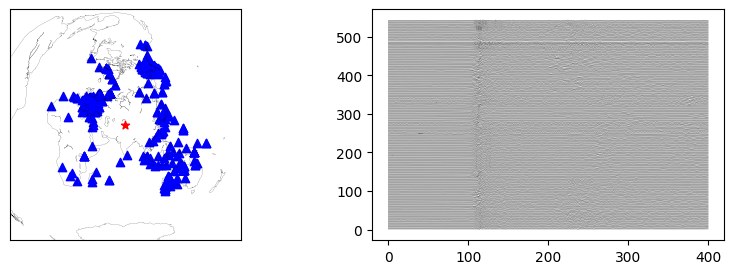

In [12]:
import bp_lib as bp_lib
bp_lib.data_plot(stream_for_bp,event_lat,event_long,'./','test')

In [13]:
from mpl_toolkits.basemap import Basemap
def array_selection_plot(stream,event_lat,event_long,az_min,az_max,dist_min,dist_max):
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(10,3))
    #map =  Basemap(projection='cyl', lon_0=event_long,lat_0=event_lat,
    #        resolution='c',ax=ax[0])
    width = 28e6
    #map = Basemap(width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c',ax=ax[1])
    map = Basemap(ax=ax[0],width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c')
    stream_sorted=bp_lib.check_azimuth(stream,az_min,az_max)
    stream_sorted=bp_lib.check_distance(stream_sorted,dist_min,dist_max)
    strea_out=stream_sorted.copy()
    Ref_trace_ind =bp_lib.get_ref_station(strea_out)
    ref_trace=strea_out[Ref_trace_ind]
    count=0
    for tr in stream_sorted:
        count=count+1
        if tr.stats.station == ref_trace.stats.station:
            map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
            time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
            #tr.plot(starttime=t.stats.P_arrival-30,endtime=t.stats.P_arrival+60,type='relative')
            #tr.plot(type='relative')
            tr.normalize()
            cut = tr.data  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            #cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) #+ count
            cut=cut +count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            ax[1].plot(time,cut,color='red',linewidth=0.8)
            #ax[1].plot(time,tr.data,color='gray')
        else:
            map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
            time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
            #tr.plot(starttime=t.stats.P_arrival-30,endtime=t.stats.P_arrival+60,type='relative')
            #tr.plot(type='relative')
            tr.normalize()
            cut = tr.data  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            #cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) #+ count
            cut=cut +count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            ax[1].plot(time,cut,color='grey',linewidth=0.5)
            #ax[1].plot(time,tr.data,color='gray')
    map.scatter(event_long,event_lat,latlon=True,facecolor='red',marker='*')
    map.drawcoastlines(linewidth=0.1)
    x, y = map(event_long, event_lat)
    #focmecs = Focal_mech
    #ax = plt.gca()
    #b = beach(focmecs, xy=(x, y), width=10, linewidth=1, alpha=0.85)
    #b.set_zorder(10000000)
    #ax.add_collection(b)
    ## plot traces
    plt.show()
    #fig.savefig(outdir+'/'+outname)

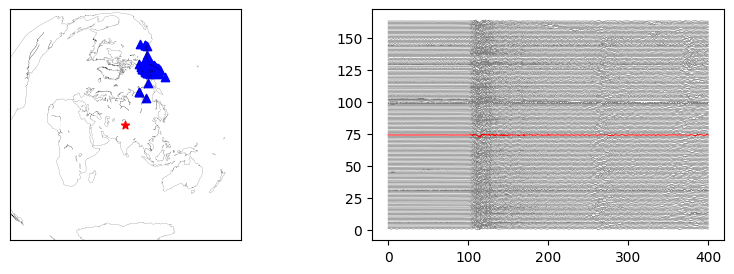

In [20]:
az_min=0
az_max=40
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

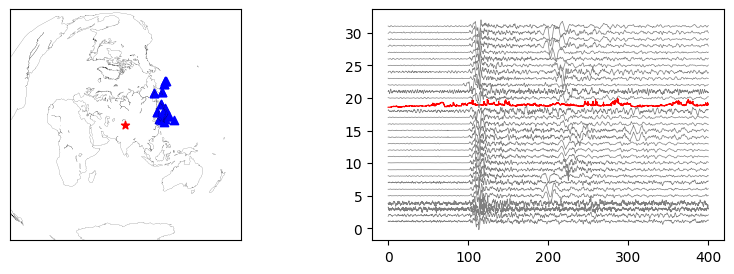

In [21]:
az_min=40
az_max=90
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

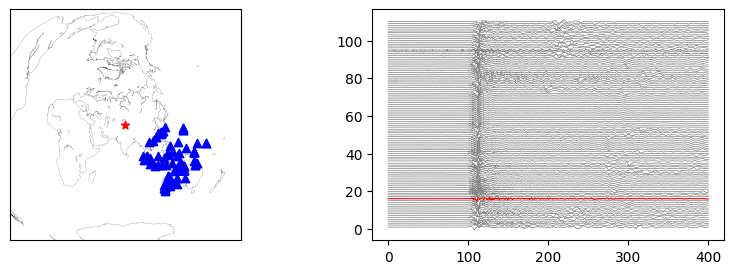

In [22]:
az_min=90
az_max=160
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

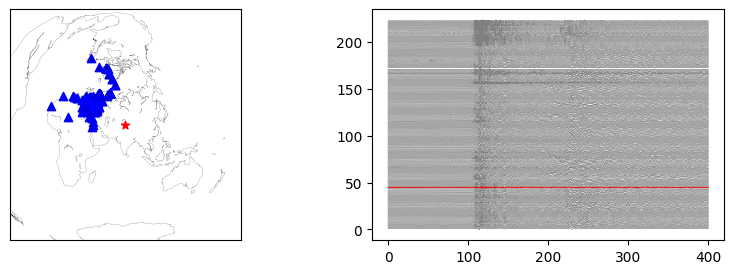

In [29]:
az_min=-120
az_max=0
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

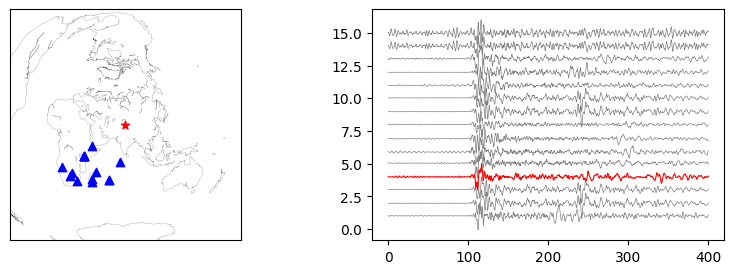

In [30]:
az_min=-179
az_max=-120
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

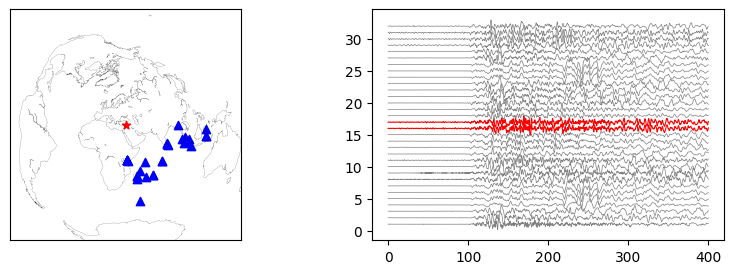

In [44]:
az_min=90
az_max=180
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

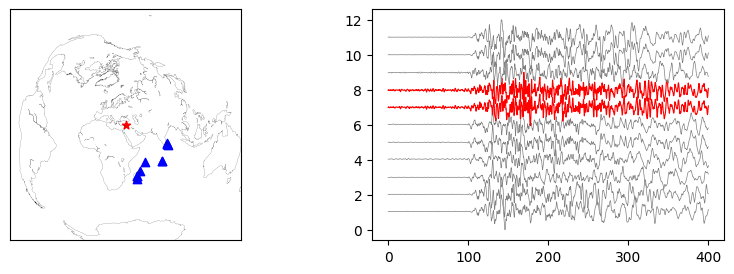

In [41]:
az_min=100
az_max=170
dist_min=30
dist_max=60
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

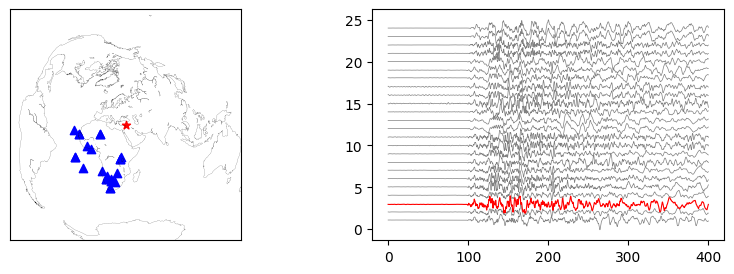

In [42]:
az_min=-179
az_max=-90
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

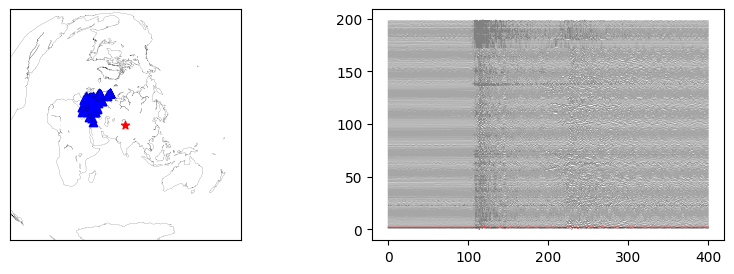

In [31]:
az_min=-90
az_max=-20
dist_min=35
dist_max=60
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

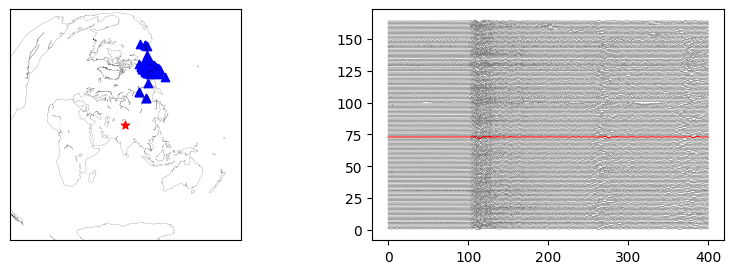

In [148]:
az_min=-10
az_max=40
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

In [23]:
az=[]
baz=[]
for t in stream_work:
    az.append(t.stats.Azimuth)
    baz.append(t.stats.Backazimuth)

In [6]:
stream_stack=stream_for_bp.copy()
st=stream_stack.stack('linear')

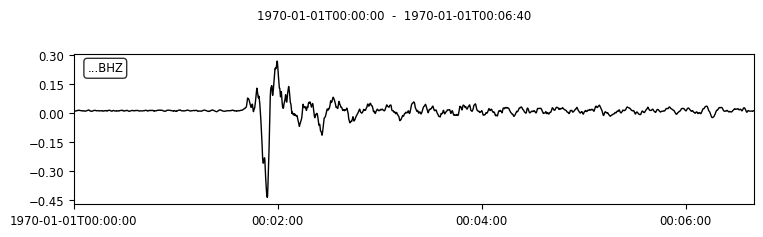

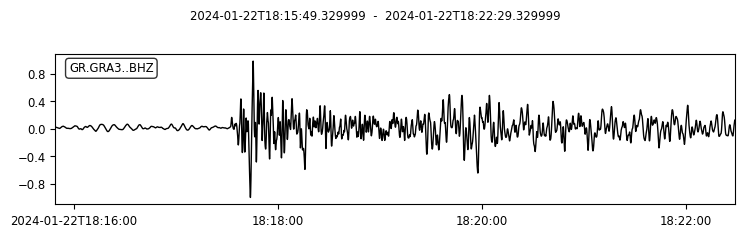

In [7]:
st.plot();
t=stream_for_bp[10]
t.plot();

          network: GR
          station: GRA3
         location: 
          channel: BHZ
        starttime: 2024-01-22T18:15:49.329999Z
          endtime: 2024-01-22T18:22:29.329999Z
    sampling_rate: 10.0
            delta: 0.1
             npts: 4001
            calib: 1.0
          Azimuth: -55.50818762435577
             Dist: 46.32020828683203
        P_arrival: 2024-01-22T18:17:29.372930Z
          _format: MSEED
            mseed: AttribDict({'dataquality': 'D', 'number_of_records': 58, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 44402688})
      origin_time: 2024-01-22T18:09:04.000000Z
       processing: ["ObsPy 1.4.0: resample(no_filter=True::sampling_rate=10.0::strict_length=False::window='hann')", 'ObsPy 1.4.0: trim(endtime=UTCDateTime(2024, 1, 22, 18, 22, 29, 372930)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2024, 1, 22, 18, 15, 49, 372930))', 'ObsPy 1.4.0: normalize(norm=None)']
 station_latitude: 49.761076
stati

(-90.0, 90.0)

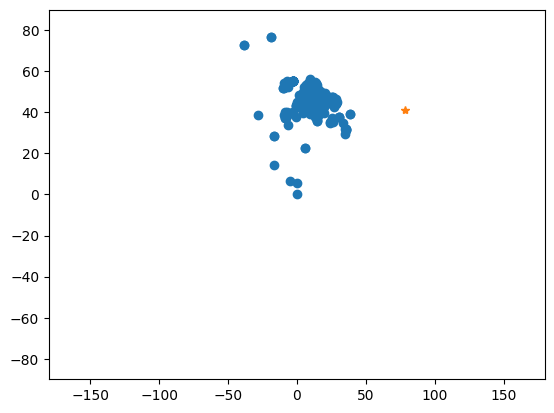

In [24]:
baz_min=45
baz_max=80
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Backazimuth >= baz_min and t.stats.Backazimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

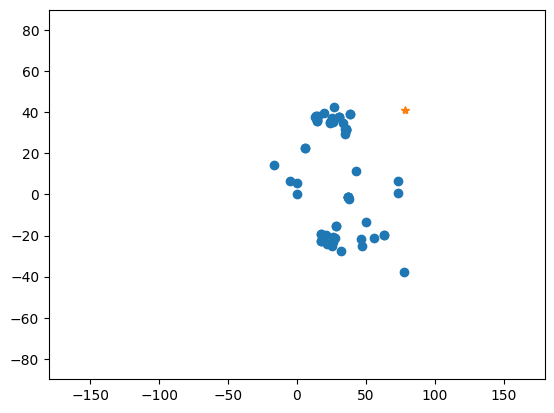

In [16]:
baz_min=-180
baz_max=-70
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

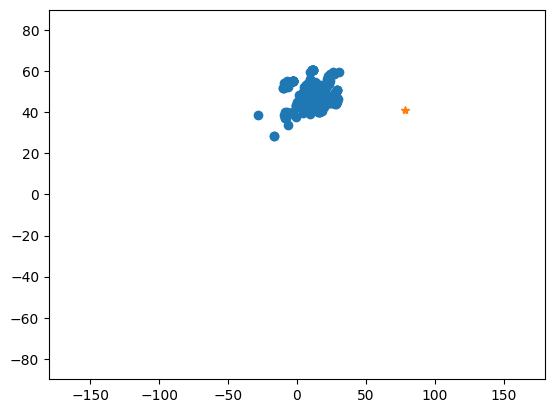

In [17]:
baz_min=-70
baz_max=-40
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

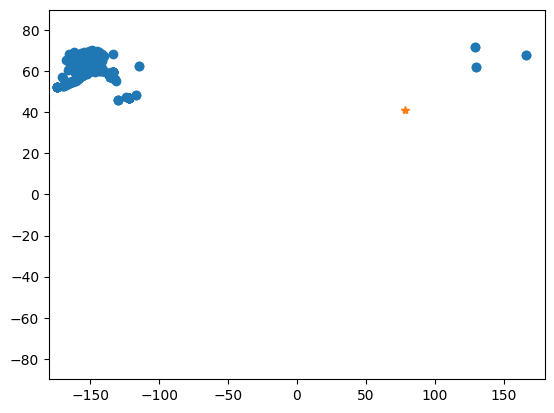

In [20]:
baz_min=-10
baz_max=40
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)